In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

In [3]:
from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.utils.twocenter_utils import fix_orbital_order

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
orbitals = {'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
            'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
            'gthszvmolopt': {6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]]
                            }}

In [5]:
cs_phase = {}
for basis in orbitals:
    cs_phase[basis] = {}
    for s in orbitals[basis]:
        cs_phase[basis][s] = [np.int32((-1)**v[2]) for v in orbitals[basis][s]]
        # cs_phase[basis][s] = []
        # for v in orbitals[basis][s]:
        #     if v[1] != 1:
        #         cs_phase[basis][s].append(1)
        #     else:
        #         cs_phase[basis][s].append(0)
# np.outer(np.array([1, -1, 1, 0]), np.array([1, -1, -1, -1]))

In [6]:
device = 'cpu'

In [231]:
workdir = './'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
# ORBS = 'gthszvmolopt'
START = 0
STOP = 4
# frames = read(f'{root}/graphene_supercell_variety/graphene_variety.xyz', slice(START, STOP))
frames = read(f'{root}/c2/C2_174.extxyz', slice(START, STOP))
for f in frames: 
    f.pbc = True

# kmesh = [15,15,1]
# kfock = [1/kmesh[0]*np.load(f"{root}/c2/cp2k/fock_{i}.npy") for i in range(START, STOP)]
# kover = [1/kmesh[0]*np.load(f"{root}/c2/cp2k/overlap_{i}.npy") for i in range(START, STOP)]

kmesh = [8,8,1]
kfock = [1/kmesh[0]*np.load(f"{root}/c2/fock_{i}_881.npy") for i in range(START, STOP)]
kover = [1/kmesh[0]*np.load(f"{root}/c2/over_{i}_881.npy") for i in range(START, STOP)]


# kmesh = [12,12,1]
# kmesh = [1,1,1]
# kfock = [1/kmesh[0]*np.load(f"{root}/graphene_supercell_variety/cp2k/fock_{i-1}.npy") for i in range(START, STOP)]
# kover = [1/kmesh[0]*np.load(f"{root}/graphene_supercell_variety/cp2k/overlap_{i-1}.npy") for i in range(START, STOP)]

for ifr in range(len(frames)):
    for ik, k in enumerate(kfock[ifr]):
        kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
        kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

# for ifr in range(len(frames)):
#     line = np.concatenate([cs_phase[ORBS][s] for s in frames[ifr].numbers])
#     cs = np.outer(line, line)
#     for ik in range(len(kfock[ifr])):
#         kfock[ifr][ik] = kfock[ifr][ik]*cs
#         kover[ifr][ik] = kover[ifr][ik]*cs

dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, 
                               fock_kspace = [kfock[ifr][:] for ifr in range(len(frames))], 
                               overlap_kspace = [kover[ifr][:] for ifr in range(len(frames))],
                               device = device, orbs = orbitals[ORBS], orbs_name = ORBS)
# dataset_o = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, fock_kspace = [kover[ifr][:] for ifr in range(len(frames))] , device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

# Targets

In [232]:
from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks 

def get_targets(dataset, device ="cpu", cutoff = None, target='fock', all_pairs= True):
    if target.lower() == 'fock':
        matrices_negative = dataset._fock_realspace_negative_translations
    elif target.lower() == 'overlap':
        matrices_negative = dataset._overlap_realspace_negative_translations
    else: 
        raise ValueError('target must be fock or overlap')
    blocks = matrix_to_blocks(dataset, matrices_negative , device = device, cutoff = cutoff, all_pairs = all_pairs, target= target)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    blocks = blocks.keys_to_samples('cell_shift_a')
    blocks = blocks.keys_to_samples('cell_shift_b')
    blocks = blocks.keys_to_samples('cell_shift_c')

    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_a')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_b')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_c')
    return blocks , coupled_blocks

In [233]:
cutoff = None
# target_blocks_nc, target_coupled_blocks_nc = get_targets(dataset, cutoff = None)
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device)
target_blocks_c, target_coupled_blocks_c = get_targets(dataset, cutoff = 6, device = device)

# target_blocks_nc_over, target_coupled_blocks_nc_over = get_targets(dataset, cutoff = None, target='overlap')
# target_blocks_over, target_coupled_blocks_over = get_targets(dataset, cutoff = cutoff, target='overlap')

# Features

In [234]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH

hypers_pair = {'cutoff': 6,
               'max_radial': 4,
               'max_angular': 4,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': 10,
               'max_angular': 4,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = False
all_pairs = False
LCUT = 3

rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = False,
                      kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij, counter = dataset._translation_counter, 
                      T_dict = dataset._translation_dict)

if both_centers and not return_rho0ij:
    NU = 3
else:
    NU = 2
rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = device,
                                feature_names = rhoij.property_names)

hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = True)

{'cutoff': 6, 'max_radial': 4, 'max_angular': 4, 'atomic_gaussian_width': 0.3, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}
torch.Size([362, 1, 4]) 1
torch.Size([716, 1, 4]) 2
torch.Size([362, 3, 4]) 1
torch.Size([716, 3, 4]) 2
torch.Size([362, 5, 4]) 1
torch.Size([716, 5, 4]) 2
torch.Size([362, 7, 4]) 1
torch.Size([716, 7, 4]) 2
torch.Size([362, 9, 4]) 1
torch.Size([716, 9, 4]) 2


In [235]:
hfeat_train = hfeat 
target_train = target_coupled_blocks

# Train

## Ridge regression

In [56]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [76]:
def train_ridge(model, target_blocks, set_bias=False):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = True)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [77]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_train, 
                                  target_blocks = target_coupled_blocks_c,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_c,
                                                                         set_bias = True)
print(loss_ridge_bias)

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares 

tensor(0.0020)


## Torch

In [236]:
from mlelec.metrics import L2_loss, L2_kspace_loss

In [237]:
from mlelec.models.linear import LinearModelPeriodic

In [238]:
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.symmetry import ClebschGordanReal
target_kspace = dataset.fock_kspace #orch.stack([kfock[ifr][:1] for ifr in range(3)])
CG = ClebschGordanReal(lmax = 3, device = device)

In [261]:
model = LinearModelPeriodic(twocfeat = hfeat_train, 
                            target_blocks = target_train,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            nhidden = 128, 
                            nlayers = 1,
                            train_kspace = True)

model = model.double()
losses = []
para = {}
grad = {}
nepoch = 2000

# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, patience=50, verbose=True)
optimizers = []
schedulers = []
for i, key in enumerate(model.model):
    optimizers.append(torch.optim.AdamW(model.model[key].parameters(), lr = 1e-2))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.5, patience = 50, verbose=True))

In [262]:
kpts_train = [dataset.cells[ifr].get_scaled_kpts(dataset.cells[ifr].make_kpts(dataset.kmesh[ifr]))[:].tolist() for ifr in range(len(dataset.structures))]
nk = len(kpts_train[0])
target_kspace = [x[:nk] for x in dataset.fock_kspace]

In [263]:
seed = 1
np.random.seed(seed)
kpts_ = torch.tensor(kpts_train).to(device)

# nepoch = 10000

new_sched = True
# epoch = 2000
for epoch in range(nepoch):
    # epoch = epoch_+2000
    
    model.train(True)

    for ik, key in enumerate(model.model):
        optimizers[ik].zero_grad()
    # optimizer.zero_grad()
    
    # epoch_loss = 0
    pred = model()
    n_predictions = sum([np.prod(b.values.shape) for _, b in pred.items()])

    if epoch < 1000:
        all_losses, epoch_loss = L2_loss(pred, target_coupled_blocks_c, loss_per_block = True)
        epoch_loss = epoch_loss.item()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        for ik, loss in enumerate(all_losses):
            loss.backward(retain_graph = False)
            optimizers[ik].step()
            schedulers[ik].step(loss)
            
        # epoch_loss += tot_loss
        losses.append(epoch_loss)
    
        # for ik, (key, loss) in enumerate(model.model):
        
    else:
        if new_sched:
            pred_before_k = pred.copy()

            optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-2)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 50, verbose=True)
            # for s, o in zip(schedulers, optimizers):
            #     s = torch.optim.lr_scheduler.ReduceLROnPlateau(o, factor = 0.5, patience = 100, verbose=True)
            new_sched = False
        
        loss = L2_kspace_loss(pred, 
                              target_kspace, 
                              dataset, 
                              cg = CG, 
                              kpts = kpts_,
                              norm = 1/np.sqrt(kpts_.shape[1])
                              )

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        loss.backward(retain_graph = False)
        epoch_loss = loss.item()
        losses.append(epoch_loss)
    
        # for ik, key in enumerate(model.model):
        #     optimizers[ik].step()
        #     schedulers[ik].step(epoch_loss)
        
        optimizer.step()
        scheduler.step(epoch_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

        for key in model.model:
            if key not in para:
                para[key] = []
                grad[key] = []
            for param in model.model[key].parameters():
                param
                grad[key].append(param.grad.norm().item())
                para[key].append(param.norm().item())

    #     # validate 
    #     valpred = model.predict(hfeat_test, target_test)
    #     if loss_func == 'kspace':
    #         val_loss = L2_kspace_loss(valpred, target_test, dataset)
    #     else:
    #         val_loss = L2_loss(valpred, target_test)
        
    #     print(f"Epoch {epoch} val loss {val_loss}")


Epoch       0, train loss on all blocks 1366.4990164461, train loss per prediction 2.06515e-03
Epoch      10, train loss on all blocks  490.3373307784, train loss per prediction 1.23707e-03
Epoch      20, train loss on all blocks  157.2353169137, train loss per prediction 7.00522e-04
Epoch      30, train loss on all blocks   25.8650818103, train loss per prediction 2.84121e-04
Epoch      40, train loss on all blocks    4.1063966779, train loss per prediction 1.13208e-04
Epoch      50, train loss on all blocks    6.0680219269, train loss per prediction 1.37617e-04
Epoch      60, train loss on all blocks    4.0551243576, train loss per prediction 1.12499e-04
Epoch      70, train loss on all blocks    1.7799385122, train loss per prediction 7.45331e-05
Epoch      80, train loss on all blocks    1.2753032241, train loss per prediction 6.30890e-05
Epoch      90, train loss on all blocks    1.2866165142, train loss per prediction 6.33682e-05
Epoch     100, train loss on all blocks    1.19011

KeyboardInterrupt: 

In [82]:
from mlelec.utils.pbc_utils import blocks_to_matrix

In [264]:
def reconstruct(pred, dataset):
    reconstructed_H_ = blocks_to_matrix(pred, dataset)
    reconstructed_H = []
    reconstructed_S = []
    for ifr in range(len(reconstructed_H_)):
        reconstructed_H.append({})
        reconstructed_S.append({})
        for T in reconstructed_H_[ifr]:
            if T in dataset.overlap_realspace[ifr]:
                reconstructed_S[ifr][T] = dataset.overlap_realspace[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            elif tuple(-np.array(T)) in dataset.overlap_realspace[ifr]:
                T = tuple(-np.array(T))
                reconstructed_S[ifr][T] = dataset.overlap_realspace[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            else:
                raise ValueError()
    return reconstructed_H, reconstructed_S

In [265]:
rH_r, rS_r = reconstruct(pred_before_k, dataset)
rH_k, rS_k = reconstruct(pred, dataset)

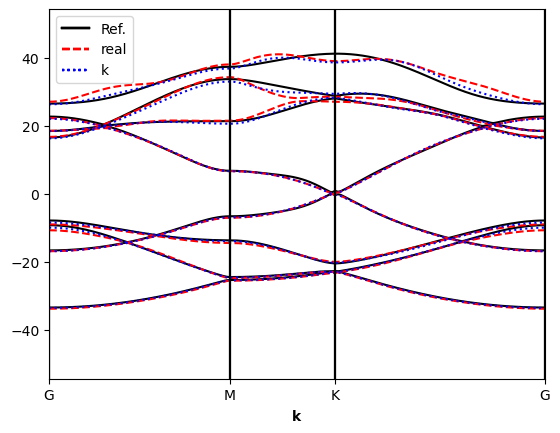

In [266]:
fig, ax = plt.subplots()

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

ifr = 0
frame = dataset.structures[ifr]
pyscf_cell = dataset.cells[ifr]
kmesh = dataset.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
realfock = np.asarray(list(dataset.fock_realspace[0].values()))
realover = np.asarray(list(dataset.overlap_realspace[0].values()))

handles = []
labels = []

ax, b, handle = plot_bands_frame_(frame, realfock, realover, pyscf_cell, [8,8,1], special_symm = 'hexagonal', kpath = kpath, ax = ax, color = 'k')
handles.append(tuple(handle))
labels.append('Ref.')

for H, S, c, ls, factor, label in zip([rH_r, rH_k], [rS_r, rS_k], ['red', 'blue'], ['--', ':'], [1, 1], ['real', 'k']): #np.sqrt(np.prod(kmesh)/len(H[0]))]):

    realfock_cutoff = np.asarray(list(H[0].values()))
    realover_cutoff = np.asarray(list(S[0].values()))
    R_vec_rel = [list(T) for T in H[0]]
    ax, b, handle = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, [8,8,1], 
                              factor = factor,
                              R_vec_rel_in = R_vec_rel, special_symm = 'hexagonal', kpath = kpath, ax = ax, color = c, ls = ls)
    handles.append(tuple(handle))
    labels.append(label)

ax.legend(handles, labels)

# nmax = 50
# for ifr in range(0, nmax):
#     frame = dataset.structures[ifr]
#     pyscf_cell = dataset.cells[ifr]
#     kmesh = dataset.kmesh[ifr]
#     kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
#     realfock = np.asarray(list(dataset.fock_realspace[ifr].values()))
#     realover = np.asarray(list(dataset.overlap_realspace[ifr].values()))
#     realfock_cutoff = np.asarray(list(reconstructed_H[ifr].values()))
#     realover_cutoff = np.asarray(list(reconstructed_S[ifr].values()))
#     fig, ax = plt.subplots()
#     ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax=ax,color = cmap((ifr+1)/nmax))
#     ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax = ax, color = 'k', ls = ':')



(1900, 2500)

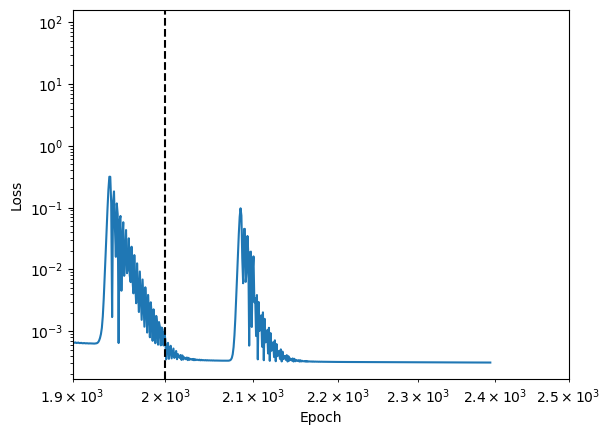

In [193]:
plt.loglog(losses, '-')
plt.axvline(2000, color = 'k', ls = '--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(1900, 2500)
# plt.ylim(1e-2,1)

(1900, 2500)

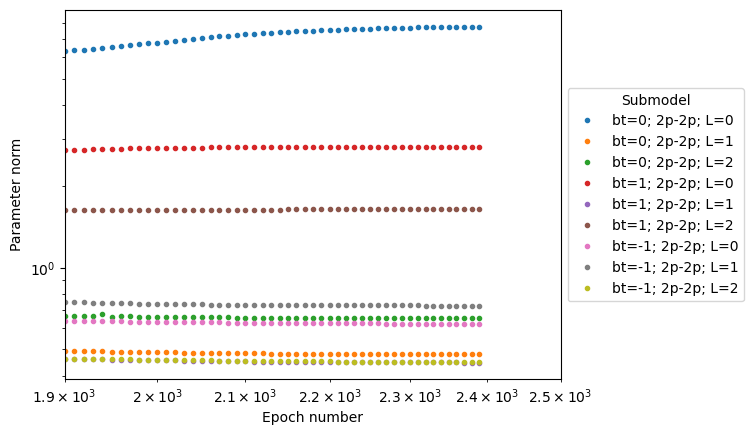

In [194]:
o = {0: 's', 1: 'p'}

fig, ax = plt.subplots()

for key in para:
    bt, _, n1, l1, _, n2, l2, L = np.int32(key[1:-1].split(','))
    if n1 == 2 and l1 == 1 and n2 == 2 and l2 == 1:
        ax.loglog(np.arange(len(para[key]))*10, para[key], '.', label = f'bt={bt}; {n1}{o[l1]}-{n2}{o[l2]}; L={L}')
ax.legend(title = 'Submodel', loc = 'center left', bbox_to_anchor = (1, 0.5))
ax.set_xlabel('Epoch number')
ax.set_ylabel('Parameter norm')
ax.set_xlim(1900, 2500)

(800, 3142.807609420889)

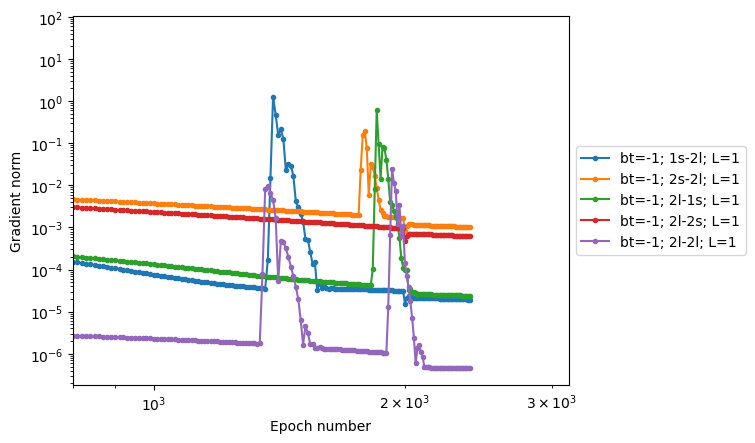

In [209]:
o = {0: 's', 1: 'l'}

fig, ax = plt.subplots()

for key in grad:
    bt, _, n1, l1, _, n2, l2, L = np.int32(key[1:-1].split(','))
    if bt == -1 and L == 1:
        ax.loglog(np.arange(len(grad[key]))*10, grad[key], '.-', label = f'bt={bt}; {n1}{o[l1]}-{n2}{o[l2]}; L={L}')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
ax.set_xlabel('Epoch number')
ax.set_ylabel('Gradient norm')
ax.set_xlim(800)


# TODO: build model for 1s-1s interaction

In [179]:
weights = {}
for i, p in enumerate(model.parameters()):
    # if i//2 not in weights:
        # weights[i//2] = {}
        # weights[i//2][0] = p.data
    # else:
        # weights[i//2][1] = p.data
    weights[i] = p.data

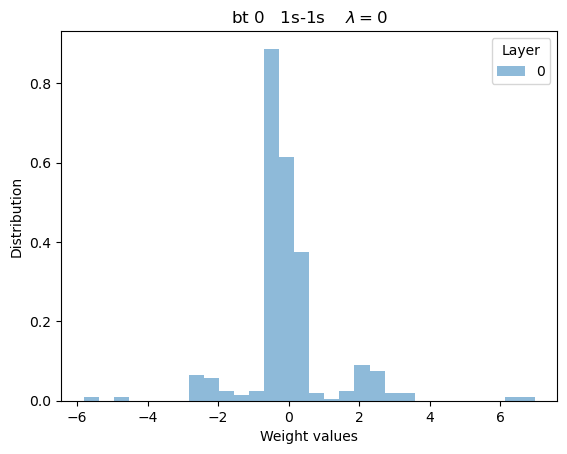

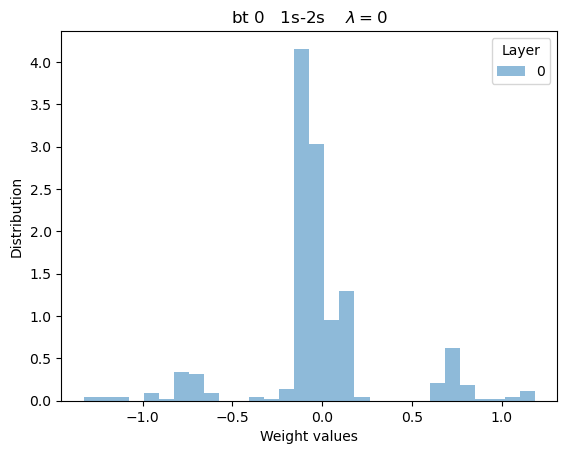

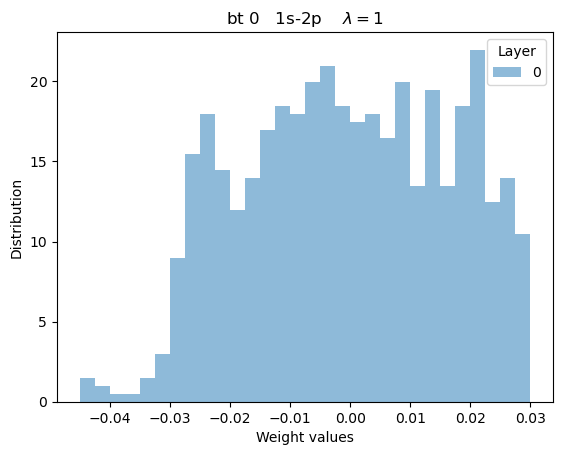

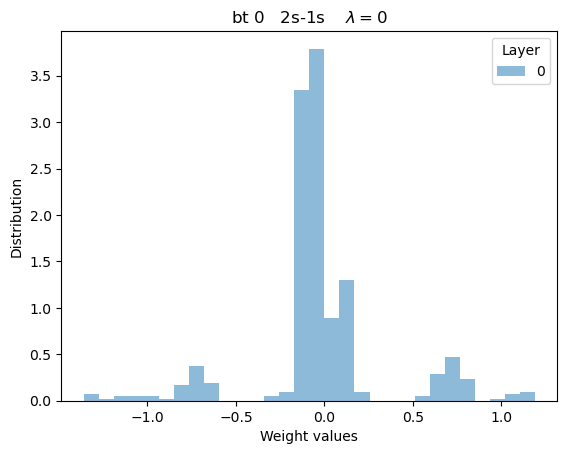

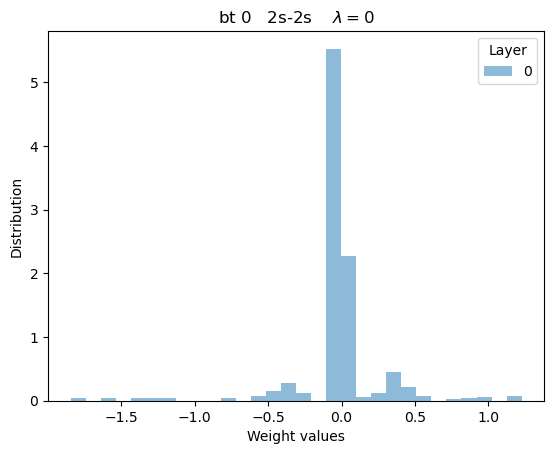

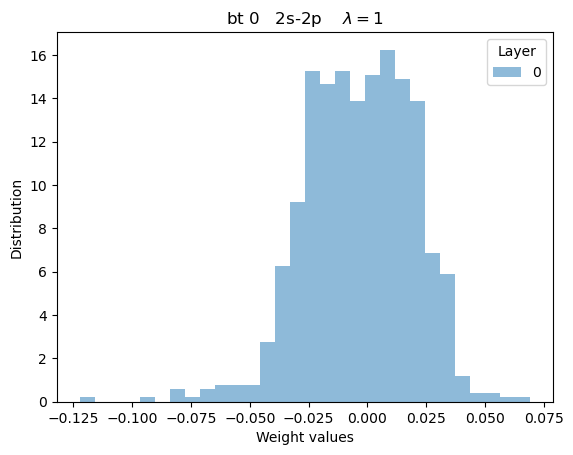

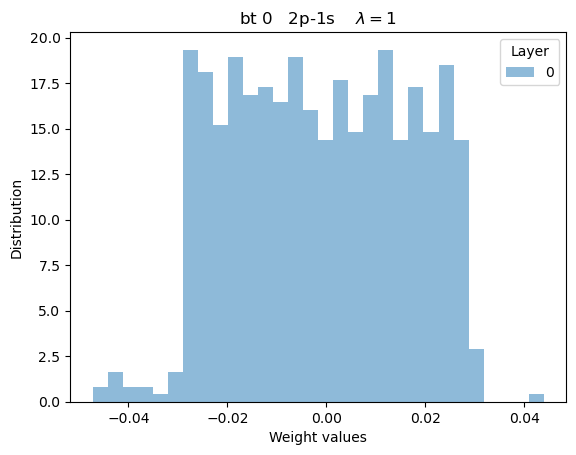

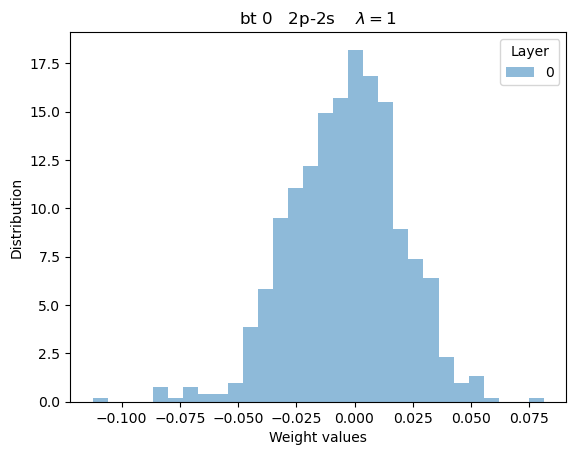

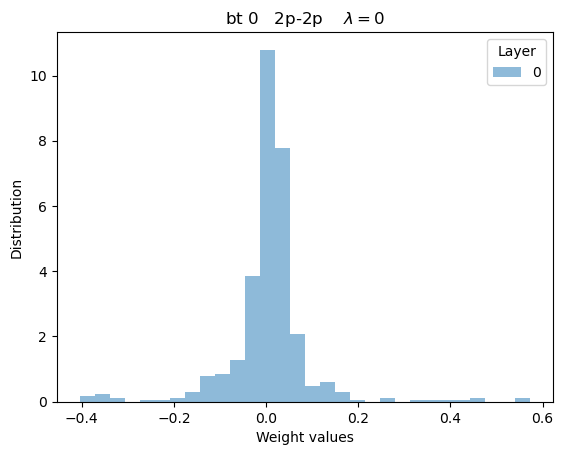

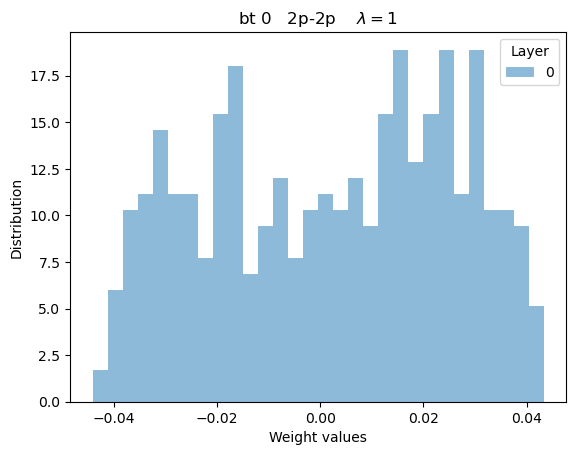

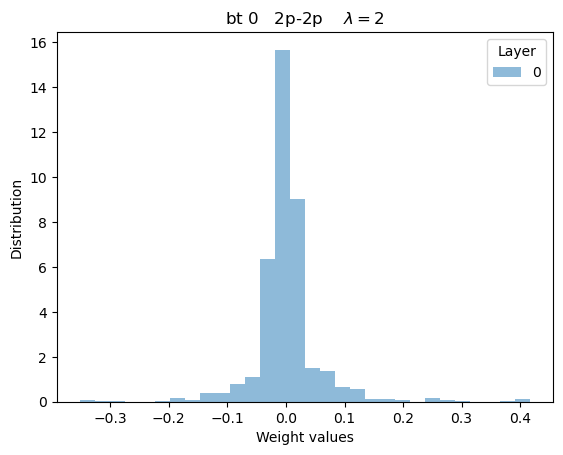

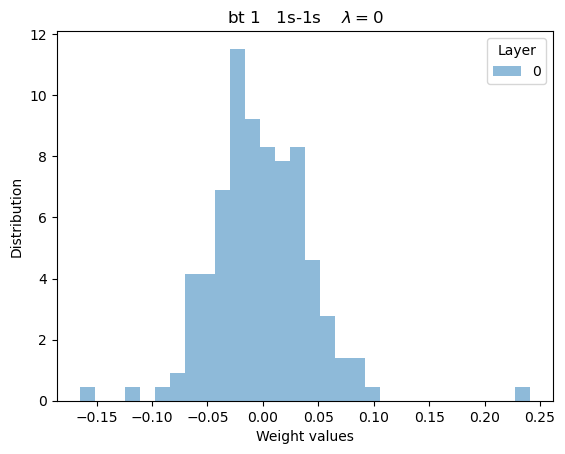

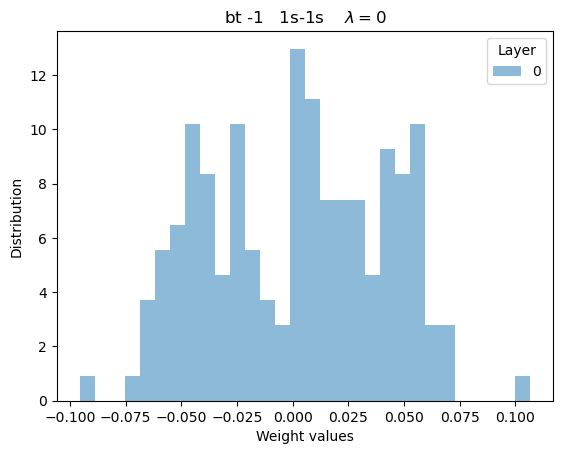

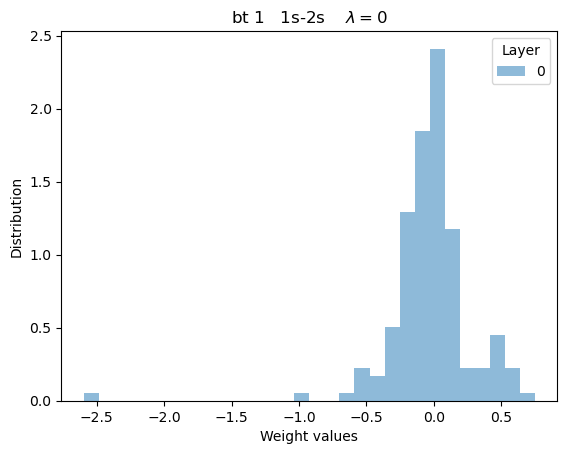

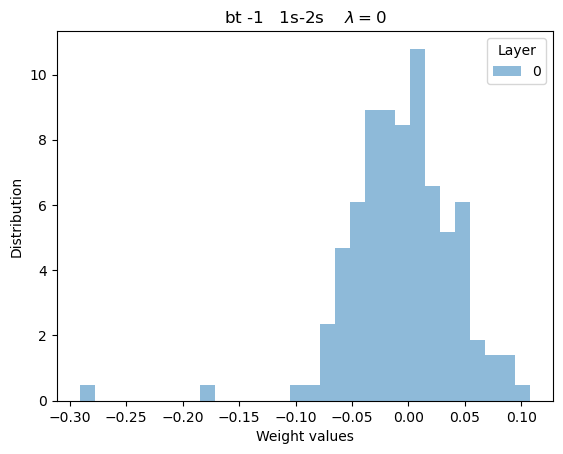

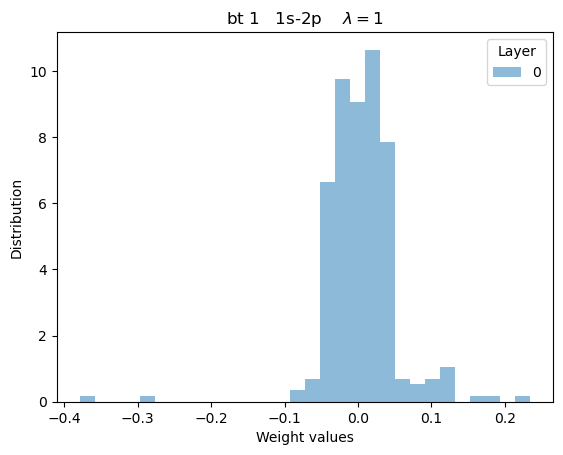

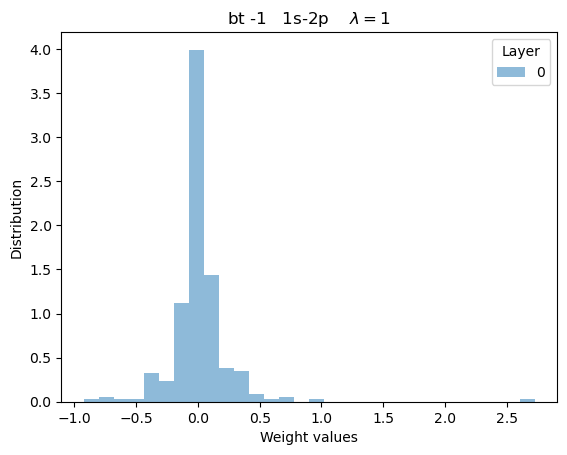

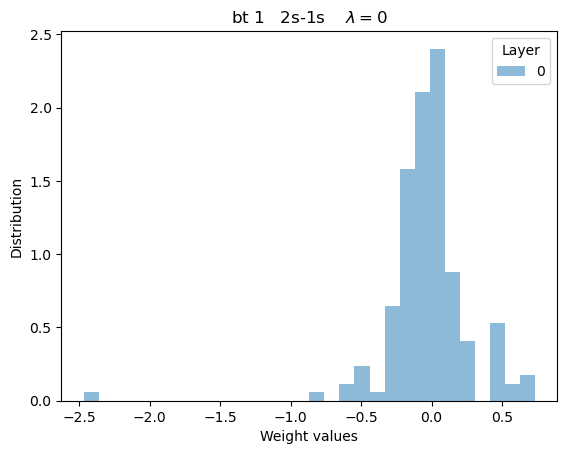

In [180]:
orb_labels = {0: 's', 1: 'p', 2: 'd'}
for i in range(18):
    fig, ax = plt.subplots()
    bt, _, n0, l0, _, n1, l1, L = pred.keys[i].values
    title = f'bt {bt}   {n0}{orb_labels[l0]}-{n1}{orb_labels[l1]}    $\lambda={L}$'
    # for j in range(1):
        # ax.hist(weights[i][j].flatten().detach().cpu(), alpha = 0.5, density = True, bins = 30, label = j)
    ax.hist(weights[i].flatten().detach().cpu(), alpha = 0.5, density = True, bins = 30, label = j)
    ax.set_title(title)
    ax.legend(title='Layer')
    ax.set_xlabel('Weight values')
    ax.set_ylabel('Distribution')

In [47]:
for k, b in hfeat.items():
    print()
    print(k)
    for sample in b.values:
        print('{:.3f} {:.3f}'.format(torch.norm(sample).item(), torch.var(sample).item()))


LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6, block_type=0)
3.234 0.017
3.234 0.017

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=1, species_center=6, species_neighbor=6, block_type=0)
0.157 0.000
0.157 0.000

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=2, species_center=6, species_neighbor=6, block_type=0)
4.121 0.003
4.121 0.003

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=3, species_center=6, species_neighbor=6, block_type=0)
3.600 0.002
3.600 0.002

LabelsEntry(order_nu=2, inversion_sigma=-1, spherical_harmonics_l=1, species_center=6, species_neighbor=6, block_type=0)
0.004 0.000
0.004 0.000

LabelsEntry(order_nu=2, inversion_sigma=-1, spherical_harmonics_l=2, species_center=6, species_neighbor=6, block_type=0)
0.101 0.000
0.101 0.000

LabelsEntry(order_nu=2, inversion_sigma=-1, spherical_harmonics_l=3, species_center=6, species_neighbor=6, block_type=0)
0.149 

In [51]:
target_kspace[0].shape

torch.Size([64, 10, 10])

In [71]:
for k, b in target_coupled_blocks.items():
    print()
    print(k)
    # for sample in b.values:
    #     print('{:.3e} {:.3e}'.format(torch.norm(sample).item(), torch.var(sample).item()))
    # print(np.mean([torch.norm(feature).item() for feature in b.values]), np.std([torch.norm(sample).item() for sample in b.values]))
    print('{:.3e} {:.3e}'.format(torch.norm(b.values, dim = 2).mean().item(), torch.norm(b.values, dim = 2).std().item()))


LabelsEntry(block_type=0, species_i=6, n_i=1, l_i=0, species_j=6, n_j=1, l_j=0, L=0)
1.102e+01 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=1, l_i=0, species_j=6, n_j=2, l_j=0, L=0)
2.976e+00 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=1, l_i=0, species_j=6, n_j=2, l_j=1, L=1)
4.743e-04 2.018e-04

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=0, species_j=6, n_j=1, l_j=0, L=0)
2.976e+00 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=0, species_j=6, n_j=2, l_j=0, L=0)
1.733e+00 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=0, species_j=6, n_j=2, l_j=1, L=1)
9.066e-03 4.359e-03

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=1, species_j=6, n_j=1, l_j=0, L=1)
4.743e-04 2.018e-04

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=1, species_j=6, n_j=2, l_j=0, L=1)
9.066e-03 4.359e-03

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=1, species_j=6, n_j=2, l_j=1, L=0)
7.948e-01 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=2,

In [70]:
b.values.norm(dim=2).mean(dim=0)

tensor([3.2785e-11, 4.8314e-13, 1.6071e-16, 1.6817e-12, 1.4629e-16],
       device='cuda:0')

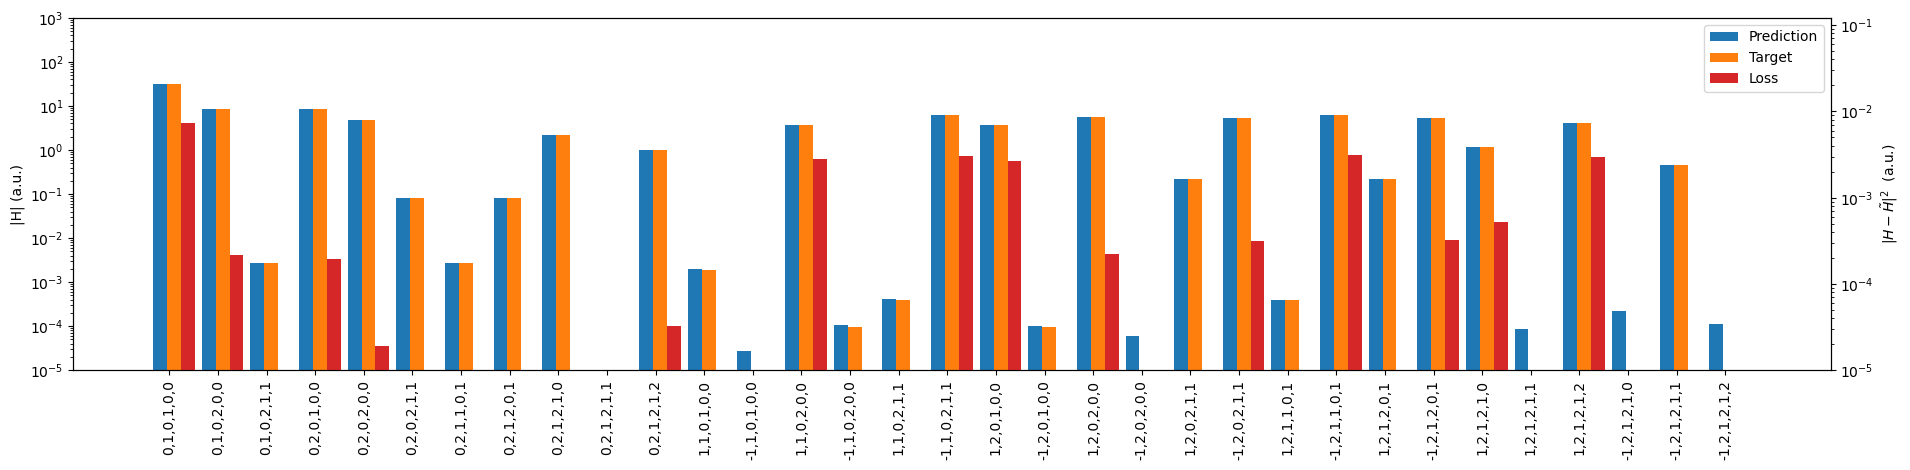

In [156]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks_c, pred_before_k, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()